In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Add this import
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

df = pd.read_csv(r"C:\Users\nitin\Desktop\controlone\Telco-Customer-Churn.csv")

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# Check for missing values
print(df.isnull().sum())

# Drop duplicates
df = df.drop_duplicates()

# Split the dataset into features (X) and target variable (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [3]:
# Drop customerID as it's not useful for modeling
df = df.drop('customerID', axis=1)

# Convert 'TotalCharges' to numeric (there are some entries that are currently strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Separate features (X) and target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


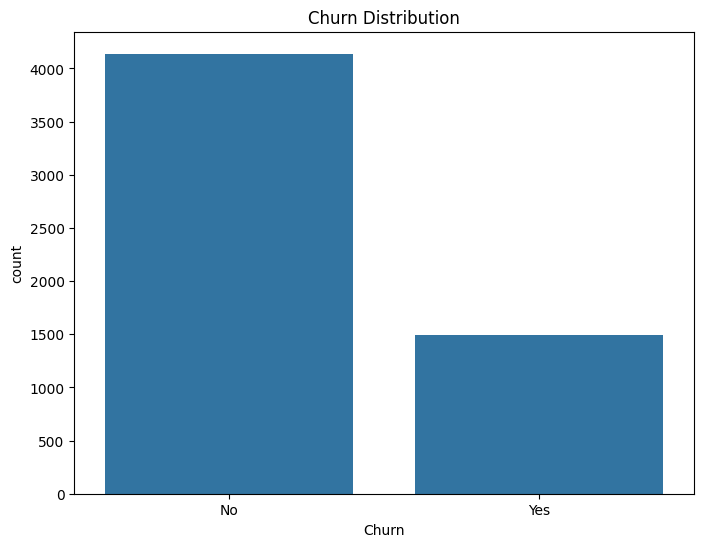

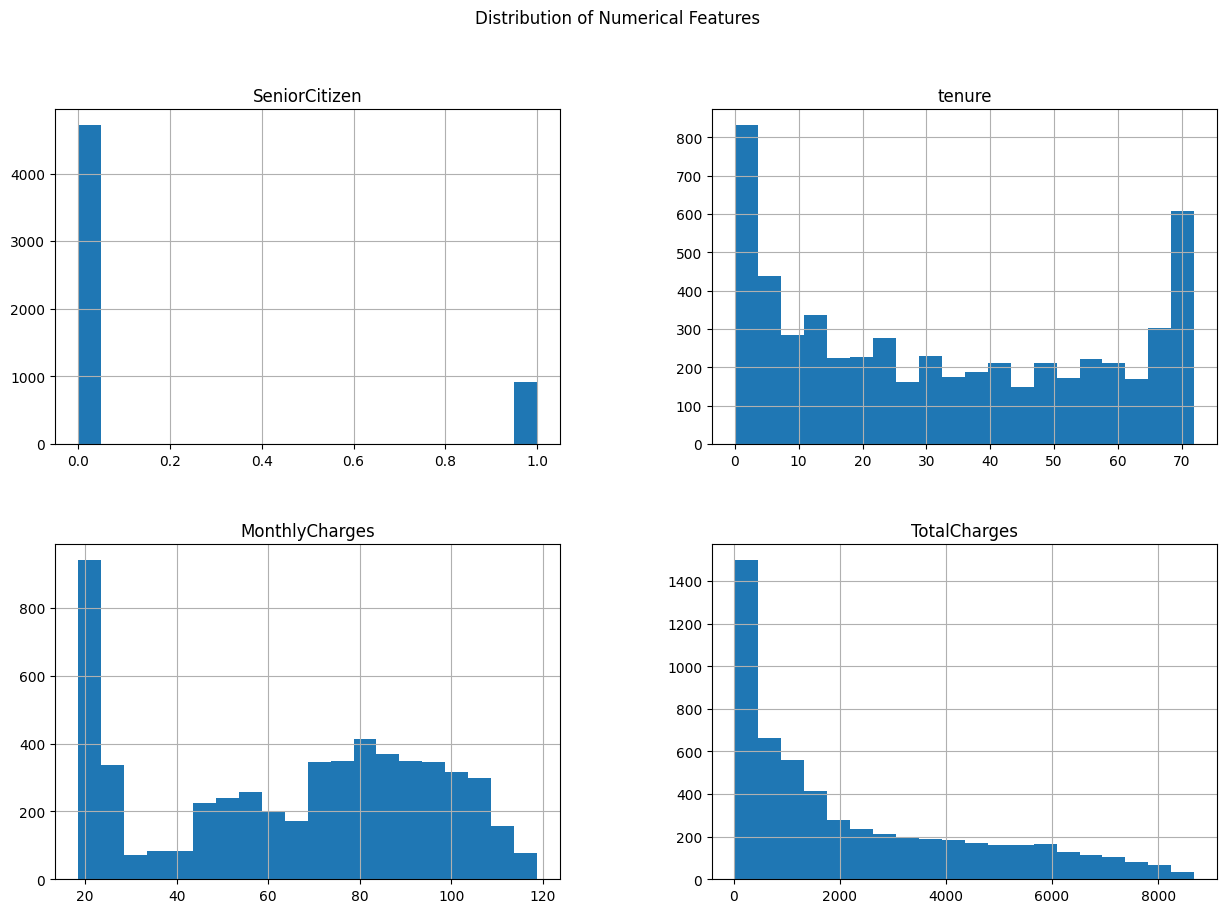

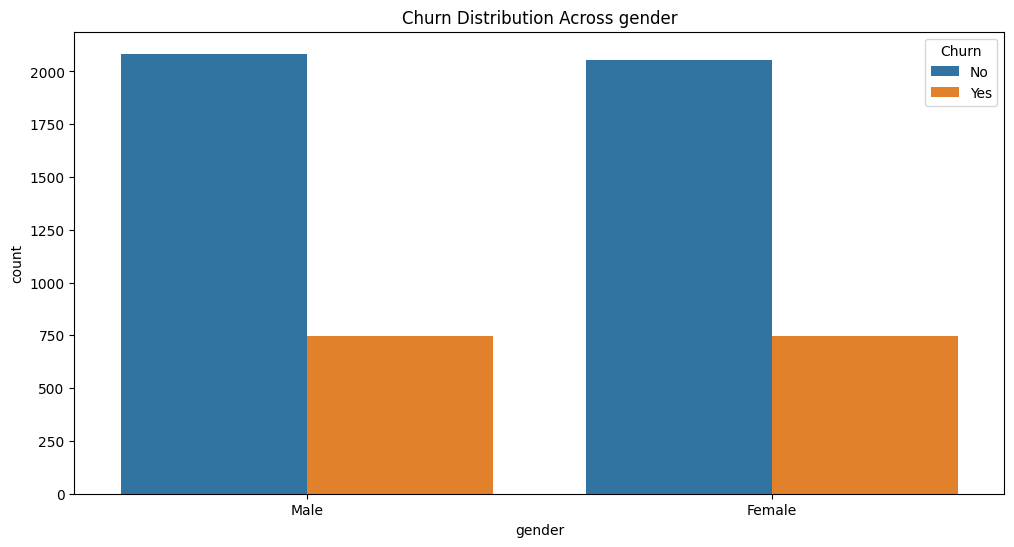

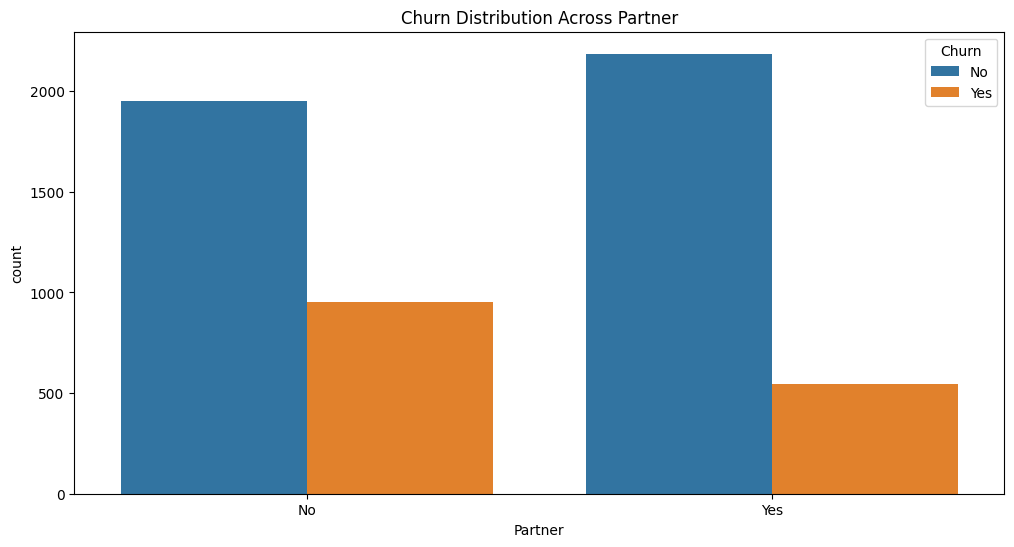

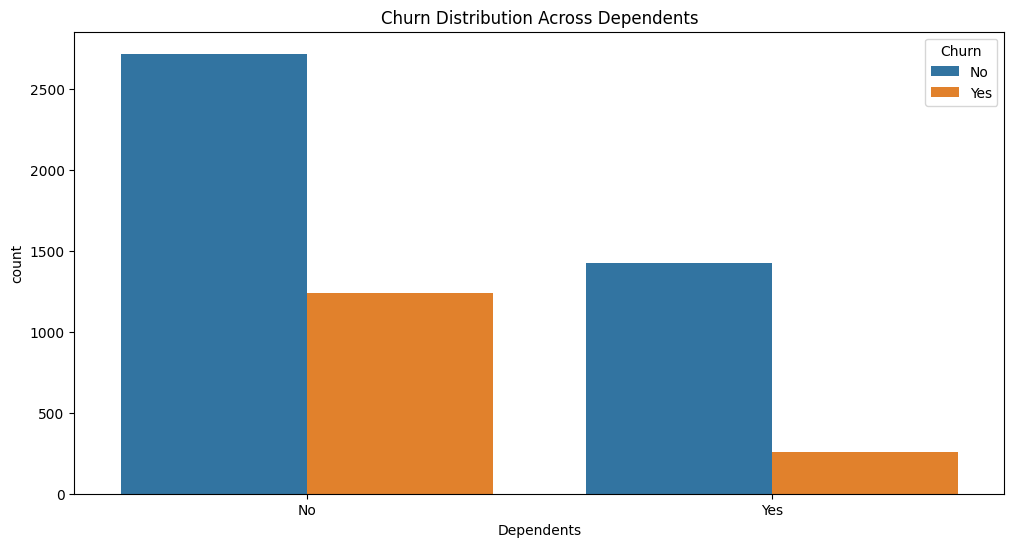

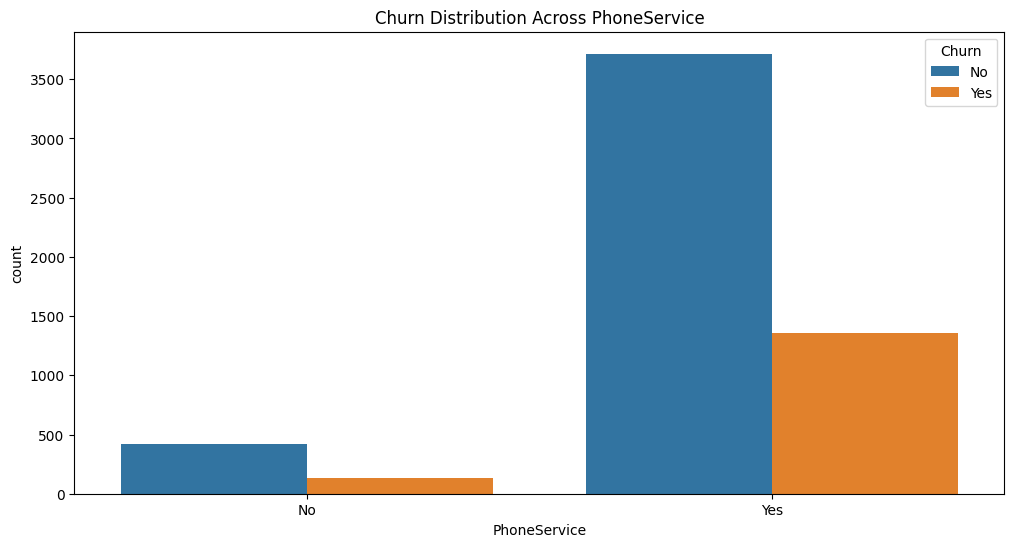

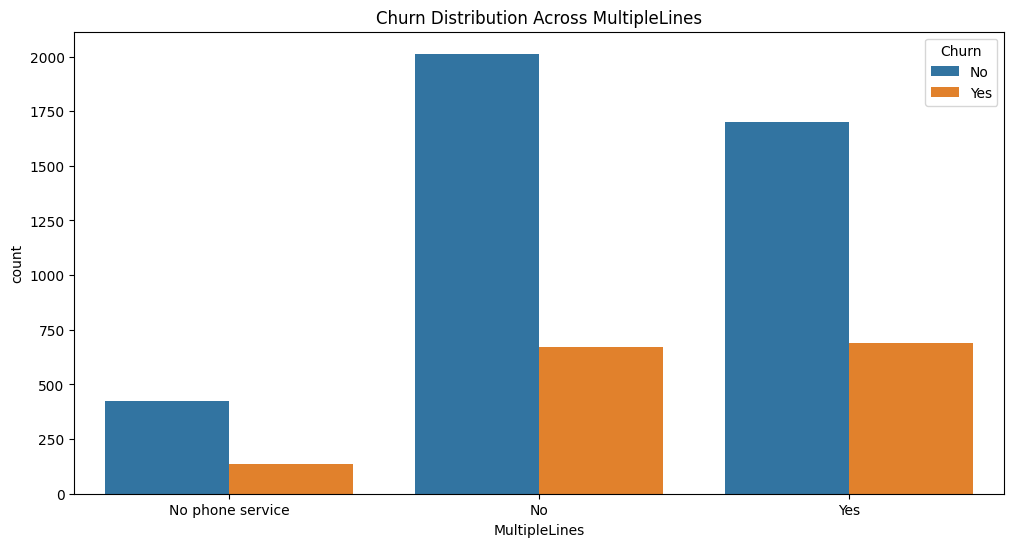

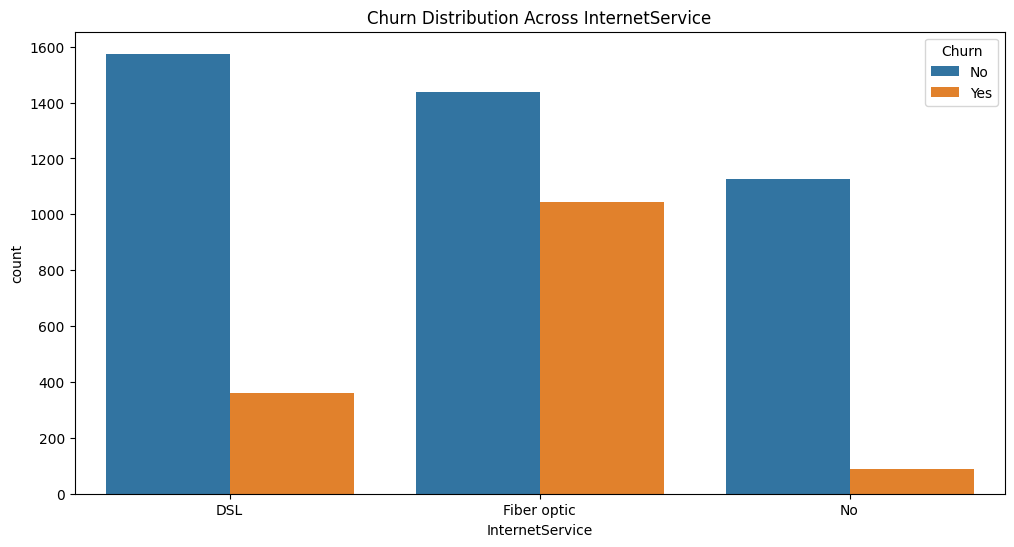

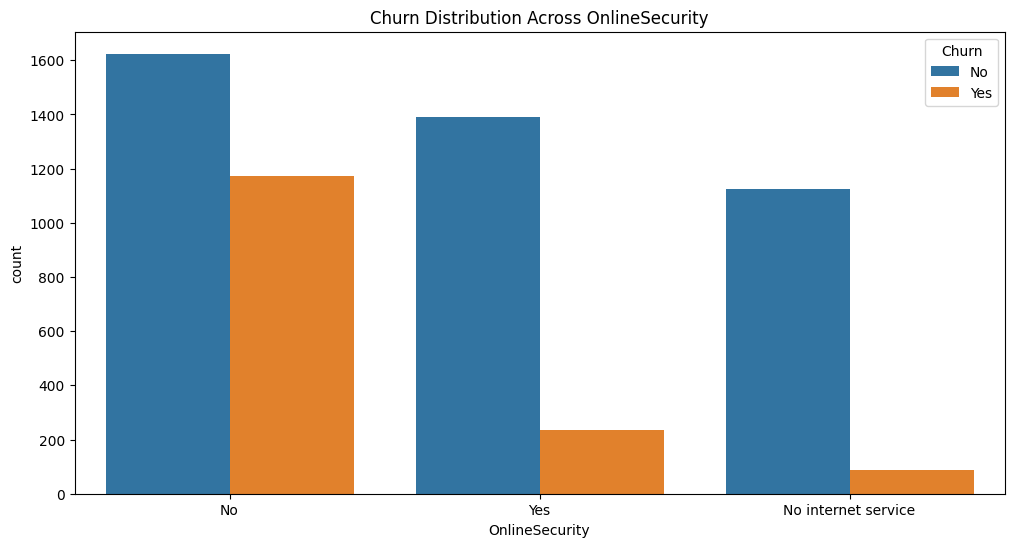

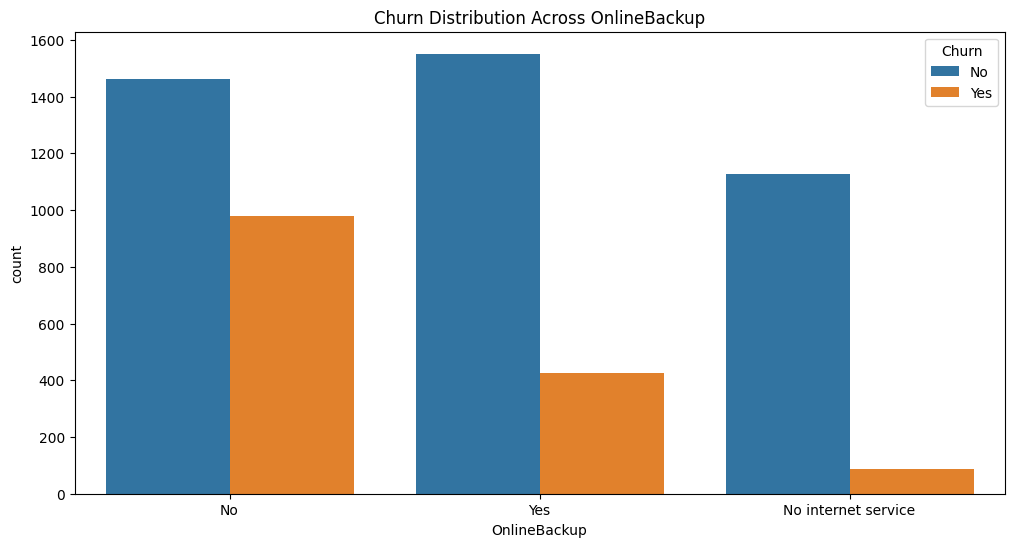

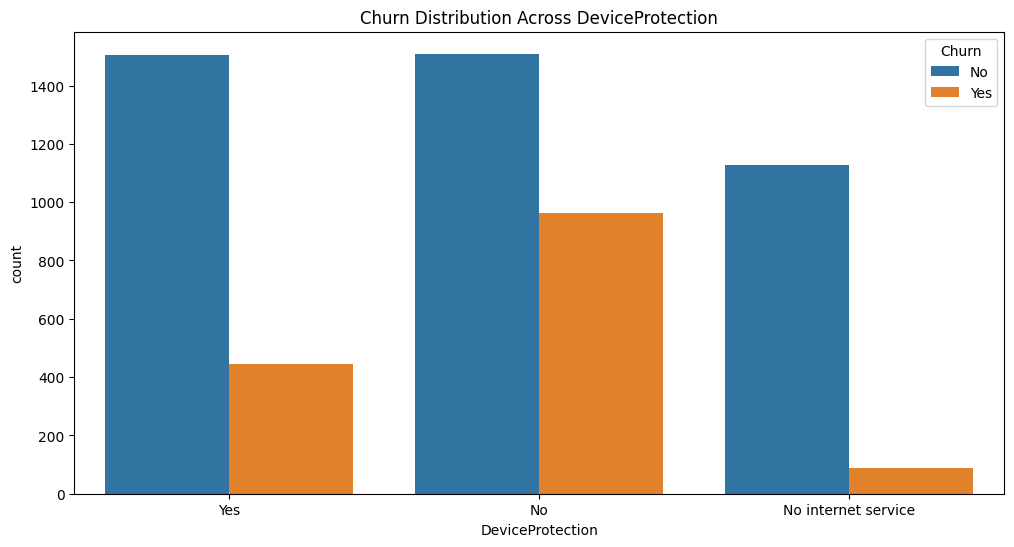

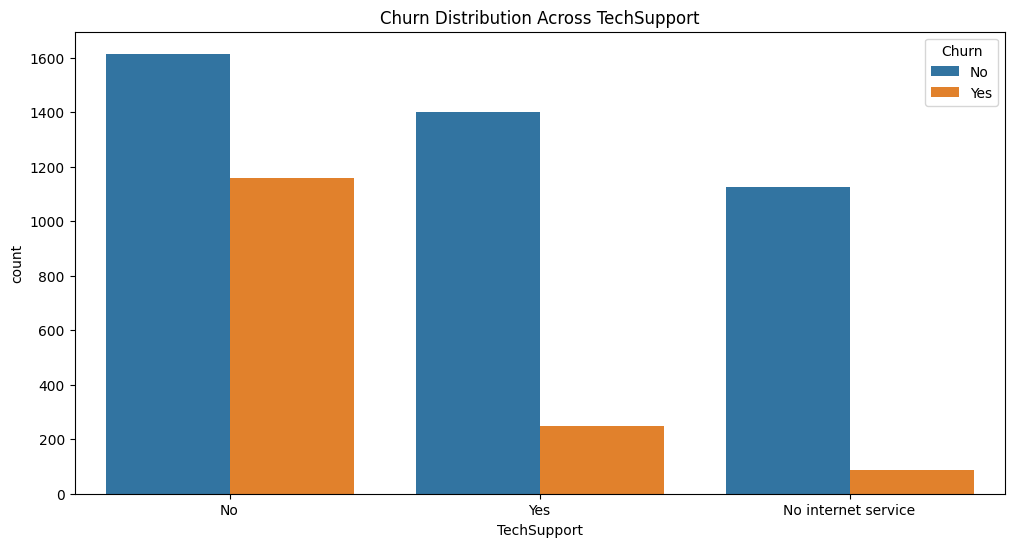

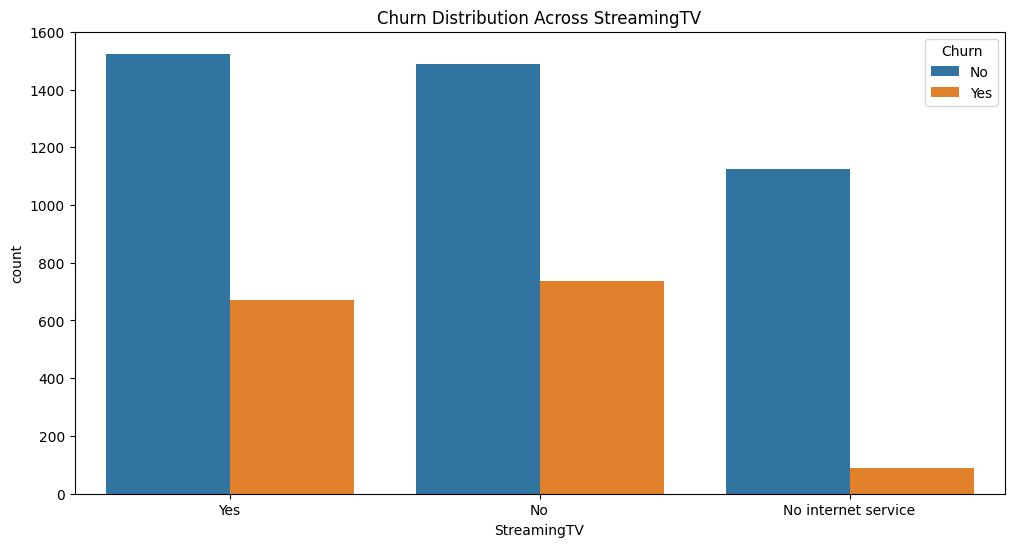

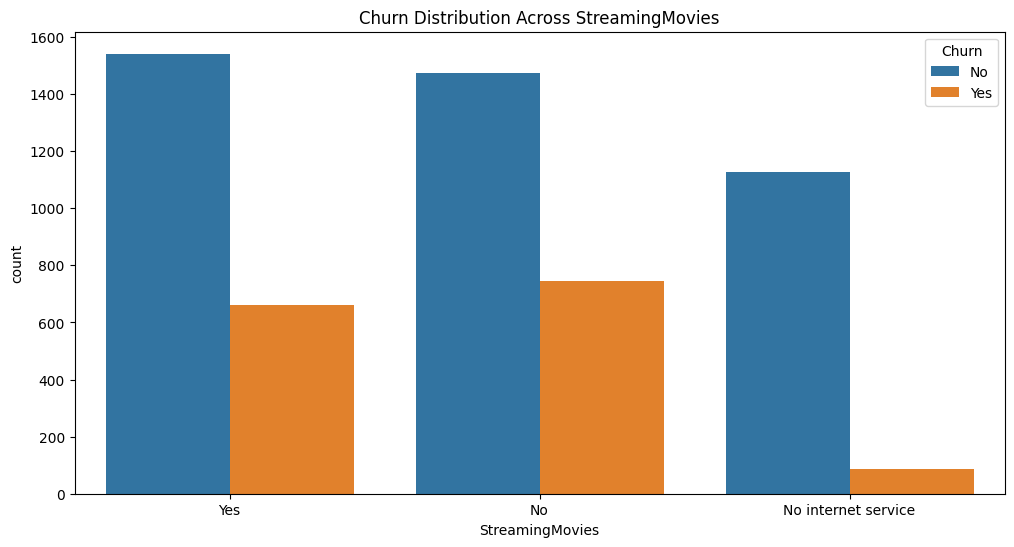

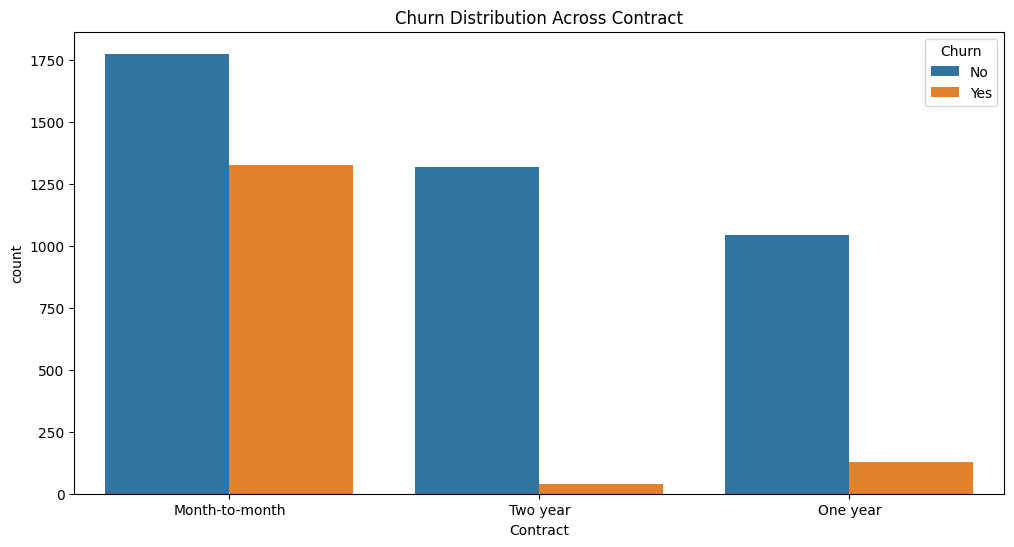

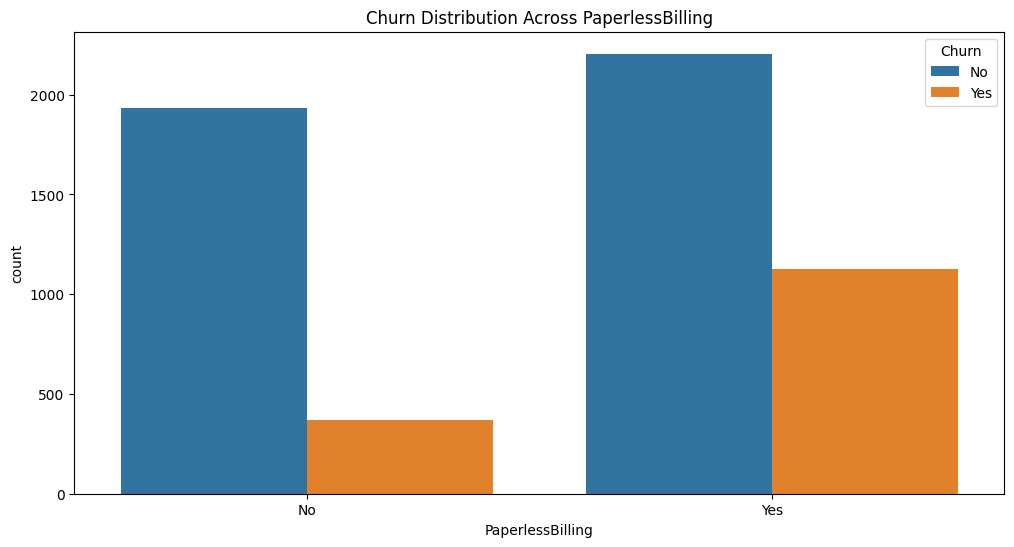

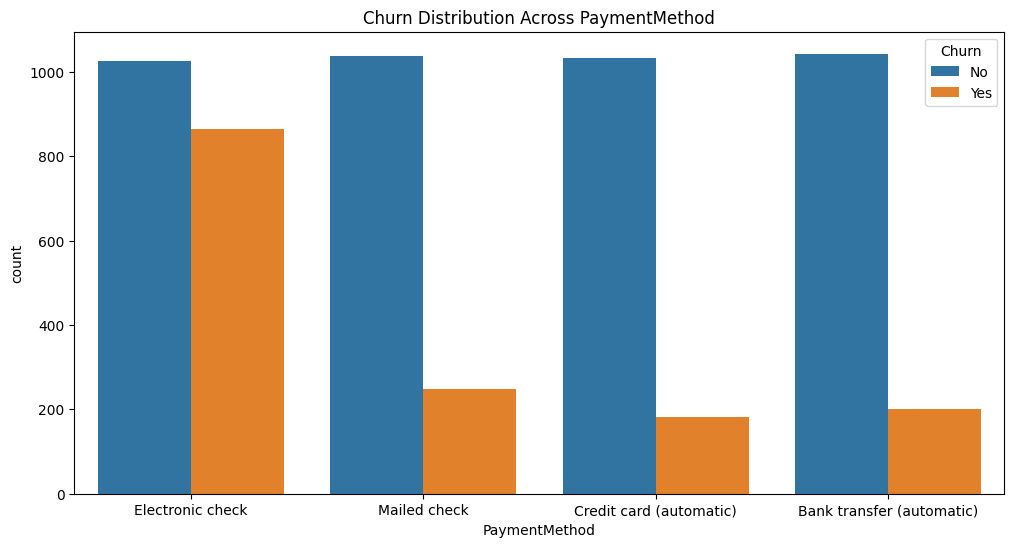

C:\Users\nitin\AppData\Local\Temp\ipykernel_6100\1389485848.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = eda_df.corr()


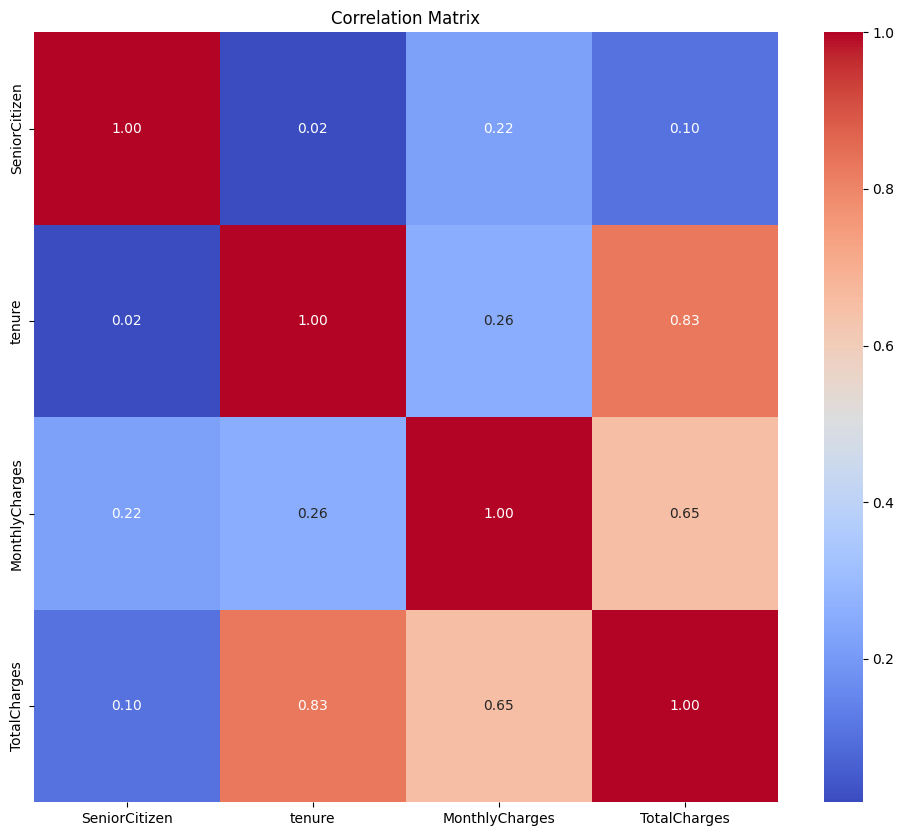

In [5]:
# Concatenate the training features and target variable for EDA
eda_df = pd.concat([X_train, y_train], axis=1)
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns

# Univariate Analysis: Churn Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="Churn", data=eda_df)
plt.title("Churn Distribution")
plt.show()

# Univariate Analysis: Numerical Features
eda_df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Bivariate Analysis: Churn vs. Categorical Features
for cat_col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=cat_col, hue="Churn", data=eda_df)
    plt.title(f"Churn Distribution Across {cat_col}")
    plt.show()

# Bivariate Analysis: Correlation Matrix
correlation_matrix = eda_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


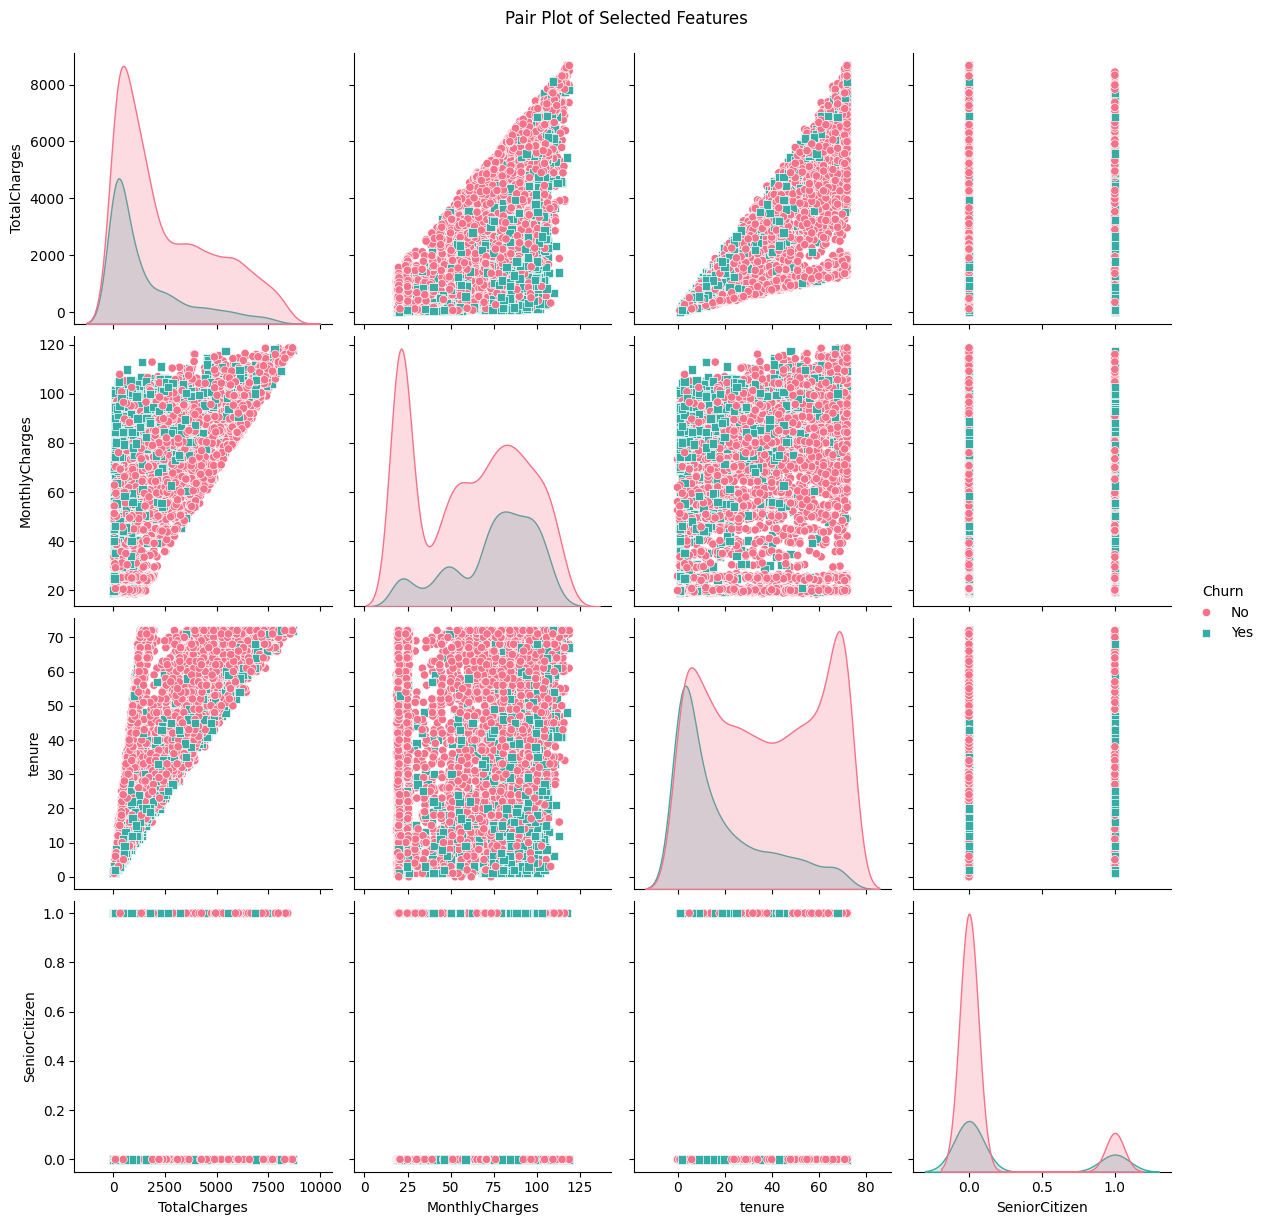

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target variable for visualization
data_for_pair_plot = X_train.copy()
data_for_pair_plot['Churn'] = y_train

# Select a subset of features for better visualization (you can adjust this based on your needs)
selected_features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen', 'Churn']
data_for_pair_plot_subset = data_for_pair_plot[selected_features]

# Create pair plot
sns.pairplot(data_for_pair_plot_subset, hue='Churn', palette='husl', markers=["o", "s"], height=3)
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()


In [8]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the training, validation, and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)


In [9]:
X_train["HasStreamingServices"] = (X_train["StreamingTV"] == "Yes") | (X_train["StreamingMovies"] == "Yes")


In [16]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_processed, y_train)

# Make predictions on the validation set
y_pred_rf_val = rf_model.predict(X_val_processed)

# Evaluate the Random Forest model on the validation set
accuracy_rf_val = accuracy_score(y_val, y_pred_rf_val)
precision_rf_val = precision_score(y_val, y_pred_rf_val, pos_label='Yes')
recall_rf_val = recall_score(y_val, y_pred_rf_val, pos_label='Yes')
f1_rf_val = f1_score(y_val, y_pred_rf_val, pos_label='Yes')
conf_matrix_rf_val = confusion_matrix(y_val, y_pred_rf_val)
class_report_rf_val = classification_report(y_val, y_pred_rf_val)

# Print evaluation metrics for the Random Forest model on the validation set
print("Random Forest Model on Validation Set:")
print(f"Accuracy: {accuracy_rf_val:.4f}, Precision: {precision_rf_val:.4f}, Recall: {recall_rf_val:.4f}, F1 Score: {f1_rf_val:.4f}")
print("Confusion Matrix:")
print(conf_matrix_rf_val)
print("Classification Report:")
print(class_report_rf_val)


Random Forest Model on Validation Set:
Accuracy: 0.7855, Precision: 0.6169, Recall: 0.5080, F1 Score: 0.5572
Confusion Matrix:
[[458  59]
 [ 92  95]]
Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.89      0.86       517
         Yes       0.62      0.51      0.56       187

    accuracy                           0.79       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.78      0.79      0.78       704



In [19]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_processed, y_train)

# Make predictions on the validation set for Gradient Boosting
y_pred_gb_val = gb_model.predict(X_val_processed)

# Evaluate the Gradient Boosting model on the validation set
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)
precision_gb_val = precision_score(y_val, y_pred_gb_val, pos_label='Yes')
recall_gb_val = recall_score(y_val, y_pred_gb_val, pos_label='Yes')
f1_gb_val = f1_score(y_val, y_pred_gb_val, pos_label='Yes')
conf_matrix_gb_val = confusion_matrix(y_val, y_pred_gb_val)
class_report_gb_val = classification_report(y_val, y_pred_gb_val)

# Print evaluation metrics for the Gradient Boosting model on the validation set
print("\nGradient Boosting Model on Validation Set:")
print(f"Accuracy: {accuracy_gb_val:.4f}, Precision: {precision_gb_val:.4f}, Recall: {recall_gb_val:.4f}, F1 Score: {f1_gb_val:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gb_val)
print("Classification Report:")
print(class_report_gb_val)

# Create and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, class_weight='balanced')
logreg_model.fit(X_train_processed, y_train)

# Make predictions on the validation set for Logistic Regression
y_pred_logreg_val = logreg_model.predict(X_val_processed)

# Evaluate the Logistic Regression model on the validation set
accuracy_logreg_val = accuracy_score(y_val, y_pred_logreg_val)
precision_logreg_val = precision_score(y_val, y_pred_logreg_val, pos_label='Yes')
recall_logreg_val = recall_score(y_val, y_pred_logreg_val, pos_label='Yes')
f1_logreg_val = f1_score(y_val, y_pred_logreg_val, pos_label='Yes')
conf_matrix_logreg_val = confusion_matrix(y_val, y_pred_logreg_val)
class_report_logreg_val = classification_report(y_val, y_pred_logreg_val)

# Print evaluation metrics for the Logistic Regression model on the validation set
print("\nLogistic Regression Model on Validation Set:")
print(f"Accuracy: {accuracy_logreg_val:.4f}, Precision: {precision_logreg_val:.4f}, Recall: {recall_logreg_val:.4f}, F1 Score: {f1_logreg_val:.4f}")
print("Confusion Matrix:")
print(conf_matrix_logreg_val)
print("Classification Report:")
print(class_report_logreg_val)


Gradient Boosting Model on Validation Set:
Accuracy: 0.8097, Precision: 0.6732, Recall: 0.5508, F1 Score: 0.6059
Confusion Matrix:
[[467  50]
 [ 84 103]]
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.90      0.87       517
         Yes       0.67      0.55      0.61       187

    accuracy                           0.81       704
   macro avg       0.76      0.73      0.74       704
weighted avg       0.80      0.81      0.80       704


Logistic Regression Model on Validation Set:
Accuracy: 0.7287, Precision: 0.4933, Recall: 0.7861, F1 Score: 0.6062
Confusion Matrix:
[[366 151]
 [ 40 147]]
Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.71      0.79       517
         Yes       0.49      0.79      0.61       187

    accuracy                           0.73       704
   macro avg       0.70      0.75      0.70       704
weighted avg       0.79      0.73      0.74

C:\Users\nitin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='f1', cv=5, n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train_processed, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for predictions
best_gb_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_gb_val = best_gb_model.predict(X_val_processed)

# Evaluate the best Gradient Boosting model on the validation set
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)
precision_gb_val = precision_score(y_val, y_pred_gb_val, pos_label='Yes')
recall_gb_val = recall_score(y_val, y_pred_gb_val, pos_label='Yes')
f1_gb_val = f1_score(y_val, y_pred_gb_val, pos_label='Yes')
conf_matrix_gb_val = confusion_matrix(y_val, y_pred_gb_val)
class_report_gb_val = classification_report(y_val, y_pred_gb_val)

# Print evaluation metrics for the best Gradient Boosting model on the validation set
print("\nBest Gradient Boosting Model on Validation Set:")
print(f"Accuracy: {accuracy_gb_val:.4f}, Precision: {precision_gb_val:.4f}, Recall: {recall_gb_val:.4f}, F1 Score: {f1_gb_val:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gb_val)
print("Classification Report:")
print(class_report_gb_val)


C:\Users\nitin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Best Gradient Boosting Model on Validation Set:
Accuracy: 0.7344, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Confusion Matrix:
[[517   0]
 [187   0]]
Classification Report:
              precision    recall  f1-score   support

          No       0.73      1.00      0.85       517
         Yes       0.00      0.00      0.00       187

    accuracy                           0.73       704
   macro avg       0.37      0.50      0.42       704
weighted avg       0.54      0.73      0.62       704



C:\Users\nitin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nitin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nitin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

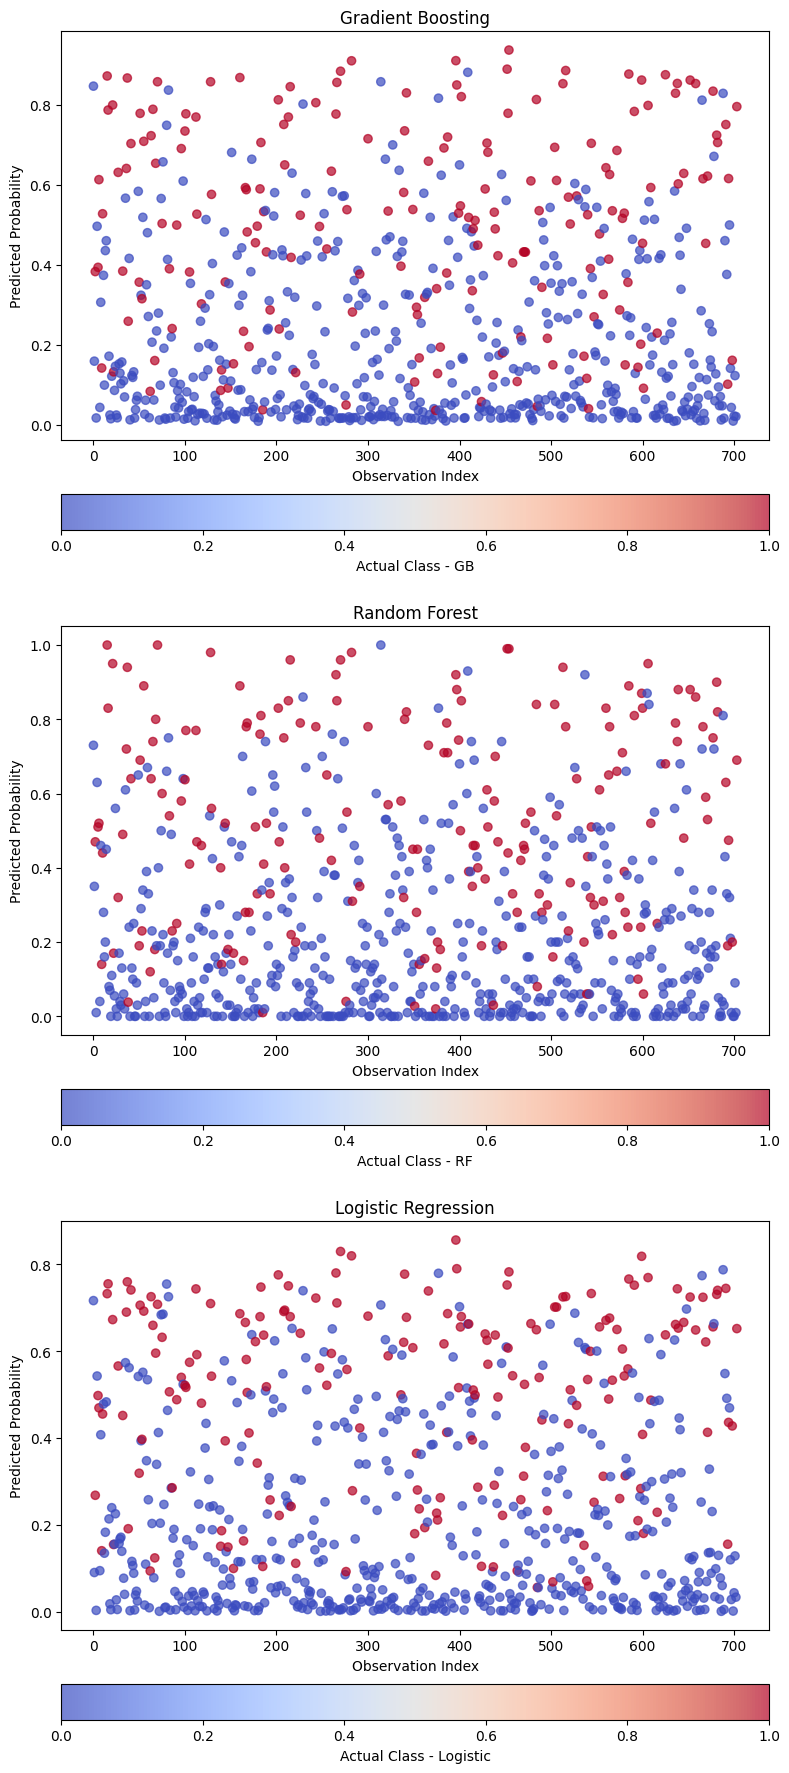

In [38]:
import matplotlib.pyplot as plt

# Assuming you have y_prob_gb_val, y_prob_rf_val, and y_prob_logistic_val available
# Replace these variables with your actual predicted probabilities

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Scatter plot for Gradient Boosting
scatter_gb = axes[0].scatter(range(len(y_prob_gb_val)), y_prob_gb_val, c=y_val_encoded, cmap='coolwarm', alpha=0.7)
axes[0].set_title('Gradient Boosting')
axes[0].set_xlabel('Observation Index')
axes[0].set_ylabel('Predicted Probability')

# Scatter plot for Random Forest
scatter_rf = axes[1].scatter(range(len(y_prob_rf_val)), y_prob_rf_val, c=y_val_encoded, cmap='coolwarm', alpha=0.7)
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Observation Index')
axes[1].set_ylabel('Predicted Probability')

# Scatter plot for Logistic Regression
scatter_logistic = axes[2].scatter(range(len(y_prob_logistic_val)), y_prob_logistic_val, c=y_val_encoded, cmap='coolwarm', alpha=0.7)
axes[2].set_title('Logistic Regression')
axes[2].set_xlabel('Observation Index')
axes[2].set_ylabel('Predicted Probability')

# Create a colorbar for each subplot
cbar_gb = fig.colorbar(scatter_gb, ax=axes[0], orientation='horizontal', pad=0.1, label='Actual Class - GB')
cbar_rf = fig.colorbar(scatter_rf, ax=axes[1], orientation='horizontal', pad=0.1, label='Actual Class - RF')
cbar_logistic = fig.colorbar(scatter_logistic, ax=axes[2], orientation='horizontal', pad=0.1, label='Actual Class - Logistic')

plt.tight_layout()
plt.show()


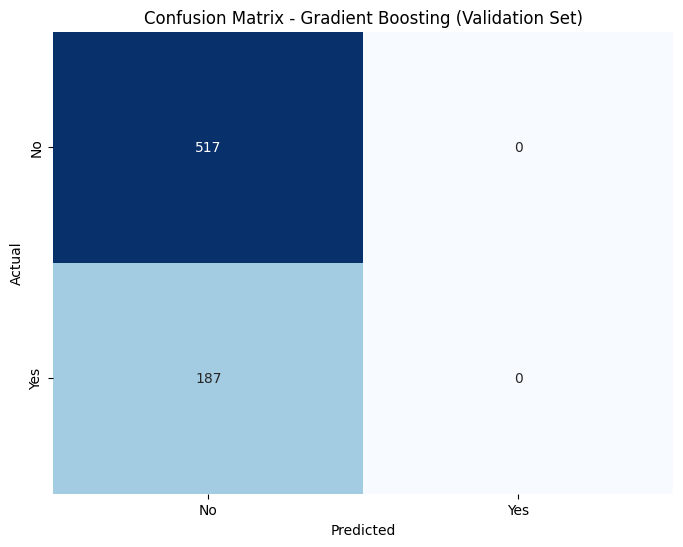

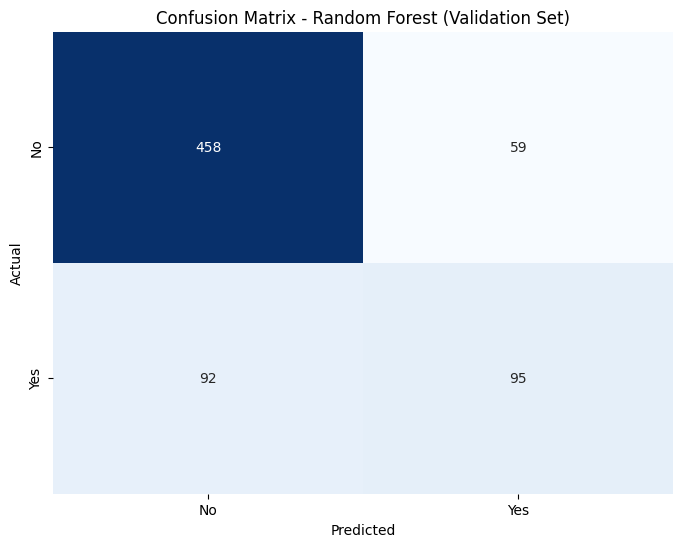

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Add other necessary imports for your models

# Assuming you have these variables available: y_val, y_pred_gb_val, y_pred_rf_val, y_pred_log_reg_val

# Confusion Matrix for Gradient Boosting model
conf_matrix_gb_val = confusion_matrix(y_val, y_pred_gb_val)

# Plot Confusion Matrix for Gradient Boosting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Gradient Boosting (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest model
conf_matrix_rf_val = confusion_matrix(y_val, y_pred_rf_val)

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Random Forest (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



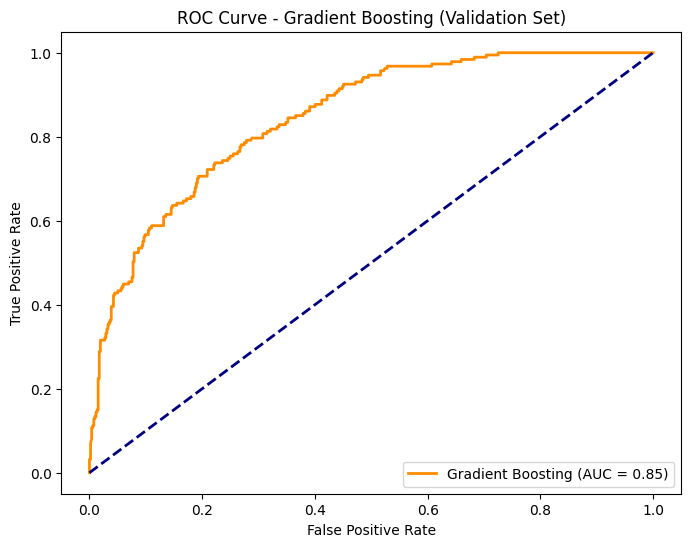

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming you have these variables available: X_train_processed, X_val_processed, y_train, y_val

# Convert string labels to numerical format
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Ensure the model is fitted on the training data
gb_model.fit(X_train_processed, y_train_encoded)

# Probability estimates for Gradient Boosting model on the validation set
y_prob_gb_val = gb_model.predict_proba(X_val_processed)[:, 1]

# ROC Curve for Gradient Boosting model
fpr_gb, tpr_gb, _ = roc_curve(y_val_encoded, y_prob_gb_val, pos_label=1)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC Curve for Gradient Boosting
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Validation Set)')
plt.legend(loc='lower right')
plt.show()


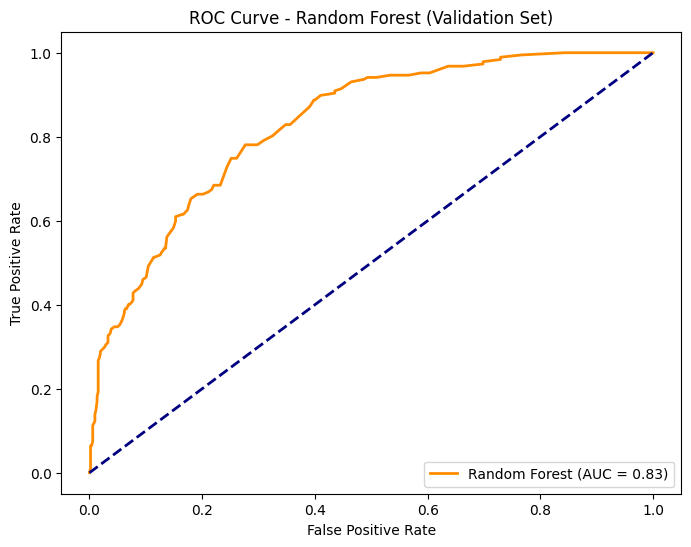

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming you have these variables available: X_train_processed, X_val_processed, y_train, y_val

# Convert string labels to numerical format
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensure the model is fitted on the training data
rf_model.fit(X_train_processed, y_train_encoded)

# Probability estimates for Random Forest model on the validation set
y_prob_rf_val = rf_model.predict_proba(X_val_processed)[:, 1]

# ROC Curve for Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(y_val_encoded, y_prob_rf_val, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Validation Set)')
plt.legend(loc='lower right')
plt.show()


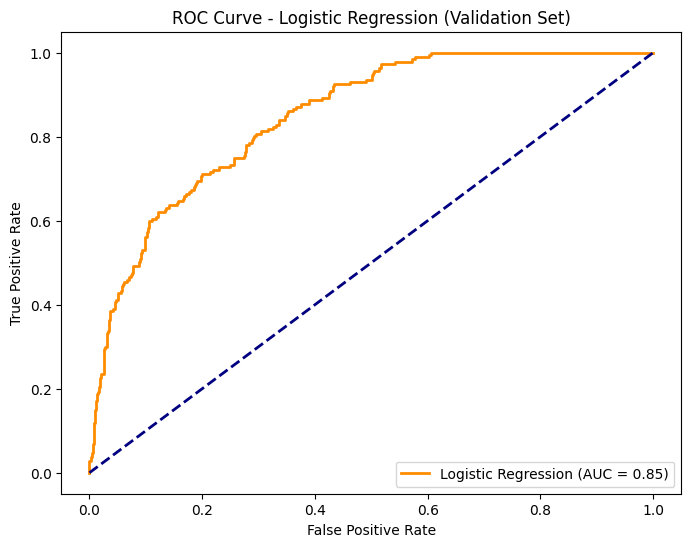

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming you have these variables available: X_train_processed, X_val_processed, y_train, y_val

# Convert string labels to numerical format
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Ensure the model is fitted on the training data
logistic_model.fit(X_train_processed, y_train_encoded)

# Probability estimates for Logistic Regression model on the validation set
y_prob_logistic_val = logistic_model.predict_proba(X_val_processed)[:, 1]

# ROC Curve for Logistic Regression model
fpr_logistic, tpr_logistic, _ = roc_curve(y_val_encoded, y_prob_logistic_val, pos_label=1)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plot ROC Curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Validation Set)')
plt.legend(loc='lower right')
plt.show()


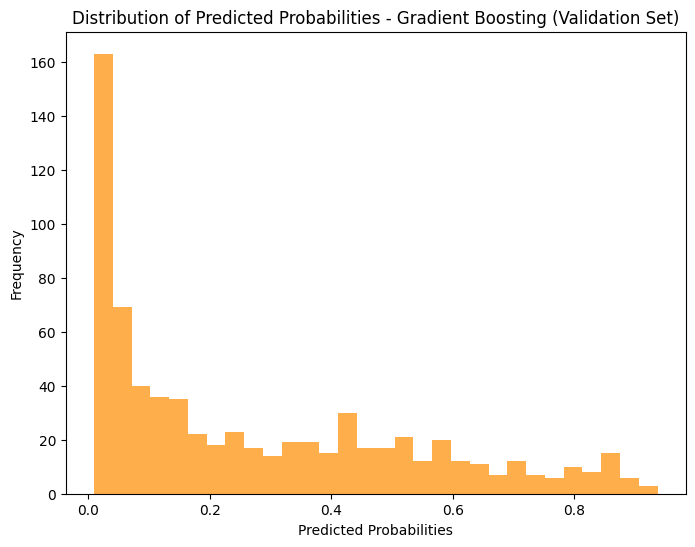

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(y_prob_gb_val, bins=30, color='darkorange', alpha=0.7)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities - Gradient Boosting (Validation Set)')
plt.show()


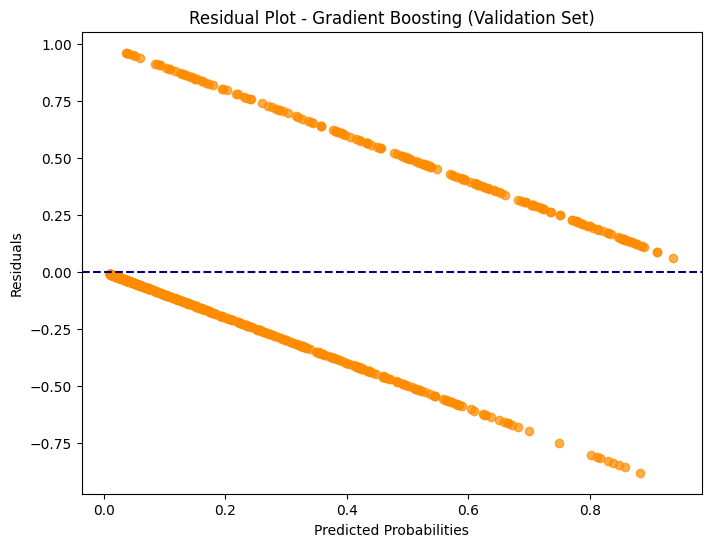

In [34]:
residuals = y_val_encoded - y_prob_gb_val

plt.figure(figsize=(8, 6))
plt.scatter(y_prob_gb_val, residuals, color='darkorange', alpha=0.7)
plt.axhline(y=0, color='navy', linestyle='--')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residual Plot - Gradient Boosting (Validation Set)')
plt.show()
